In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm.auto import tqdm


In [8]:
tickers = [
    "SPY",   # SPDR S&P 500 ETF Trust
    "AAPL",  # Apple Inc.
    "WFC",   # Wells Fargo & Co
    "XOM",   # Exxon Mobil Corp
    "JNJ",   # Johnson & Johnson
    "SBUX"   # Starbucks Corp
]

# Diccionario con tickers, nombres de empresas y sectores
empresas_dict = {
    "SPY": {"nombre": "S&P 500 ETF", "sector": "Índice", "alcance": "Global"},
    "AAPL": {"nombre": "Apple Inc.", "sector": "Tecnología / Electrónica de Consumo", "alcance": "Global"},
    "WFC": {"nombre": "Wells Fargo & Co", "sector": "Servicios Financieros / Bancario", "alcance": "Local"},
    "XOM": {"nombre": "Exxon Mobil Corp", "sector": "Petróleo y Gas", "alcance": "Global"},
    "JNJ": {"nombre": "Johnson & Johnson", "sector": "Farmacéutica y Productos de Consumo", "alcance": "Global/Local"},
    "SBUX": {"nombre": "Starbucks Corp", "sector": "Alimentación y Bebidas / Servicio de Cafeterías", "alcance": "Local"}
}


In [9]:
precios = yf.download(tickers, start="2019-01-01", end="2020-12-31")["Adj Close"] # Precios ajustados al cierre
precios = precios.dropna() # Eliminar filas con NA's

# Calcular rendimientos logarítmicos
rendimientos = np.log(precios / precios.shift(1)).dropna()


[*********************100%%**********************]  6 of 6 completed


In [6]:
# Calculate betas
betas = {}
for column in rendimientos.columns:
    cov = np.cov(rendimientos['SPY'], rendimientos[column])[0, 1]
    var = np.var(rendimientos['SPY'])
    beta = cov / var
    betas[column] = beta

# Print betas
for asset, beta in betas.items():
    print(f"Beta of {asset} with respect to SPY: {beta}")

Beta of AAPL with respect to SPY: 1.206456322945742
Beta of JNJ with respect to SPY: 0.6647198042550472
Beta of SBUX with respect to SPY: 1.1161350551619378
Beta of SPY with respect to SPY: 1.00199203187251
Beta of WFC with respect to SPY: 1.3616428835255525
Beta of XOM with respect to SPY: 1.1229811944254695


In [2]:
companies = pd.read_csv("../data/index-components-01-11-2024.csv",)
companies = companies.iloc[:-1,:] # Eliminar última fila

companies_dict = {companies["Symbol"][i]: {"name": companies["Name"][i]} for i in range(len(companies))}

In [18]:
precios = yf.download(list(companies_dict.keys()), start="2019-01-01", end="2023-12-31")["Adj Close"] # Precios ajustados al cierre

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-01-01 -> 2023-12-31)')


In [34]:
precios = pd.read_csv("../data/sp500_precios.csv", index_col=0, parse_dates=True)
precios.head(5)

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,63.381710,31.963160,37.893341,70.646538,63.908173,26.190001,131.077469,224.570007,78.138260,35.836353,...,41.850040,53.962513,35.926987,62.568439,83.576164,95.619514,156.240005,35.226196,81.659958,230.557449
2019-01-03,61.046745,29.581663,34.118874,68.318840,60.892082,25.780001,126.602242,215.699997,73.418312,35.678822,...,41.685143,53.133984,35.945953,60.423553,81.473938,93.889969,146.880005,35.031338,78.837448,225.055740
2019-01-04,63.159786,31.530161,35.575378,70.519852,62.630009,26.389999,131.524994,226.190002,75.200783,36.501442,...,42.093063,55.093021,36.988953,62.972939,83.594421,97.096619,152.970001,36.107277,81.930641,232.594147
2019-01-07,64.500923,32.425674,35.496204,71.549126,63.567928,26.330000,131.981812,229.259995,75.673691,36.685211,...,41.910801,55.379513,37.652691,62.041607,83.503029,97.134010,155.289993,36.251289,82.423607,234.428024
2019-01-08,65.446503,31.904114,36.172874,71.881653,62.804718,26.430000,135.319580,232.679993,77.519836,37.367813,...,42.396820,55.782177,37.396687,62.624863,83.338516,94.955734,156.330002,36.581703,83.651207,236.630554


In [35]:
rendimientos = np.log(precios).diff().dropna()

In [36]:
# Calculate betas
betas = {}
for column in rendimientos.columns:
    cov = np.cov(rendimientos['SPY'], rendimientos[column])[0, 1]
    var = np.var(rendimientos['SPY'])
    beta = cov / var
    betas[column] = beta

# Print betas
for asset, beta in betas.items():
    print(f"Beta of {asset} with respect to SPY: {beta}")

Beta of A with respect to SPY: 0.989972138460018
Beta of AAL with respect to SPY: 1.4246685119667024
Beta of AAPL with respect to SPY: 1.2336045377313716
Beta of ABBV with respect to SPY: 0.5991765259769651
Beta of ABT with respect to SPY: 0.8215026722399447
Beta of ACGL with respect to SPY: 1.0328378965138445
Beta of ACN with respect to SPY: 1.099514325347114
Beta of ADBE with respect to SPY: 1.2842292294719007
Beta of ADI with respect to SPY: 1.2835266786541837
Beta of ADM with respect to SPY: 0.8255459525877438
Beta of ADP with respect to SPY: 1.0363326324435895
Beta of ADSK with respect to SPY: 1.3677911222756216
Beta of AEE with respect to SPY: 0.6883931100862272
Beta of AEP with respect to SPY: 0.5923847511325835
Beta of AES with respect to SPY: 1.138474875124664
Beta of AFL with respect to SPY: 1.0092923829258889
Beta of AIG with respect to SPY: 1.3090346947948455
Beta of AIZ with respect to SPY: 0.8520886979609881
Beta of AJG with respect to SPY: 0.8778033345775527
Beta of AKAM

<Axes: >

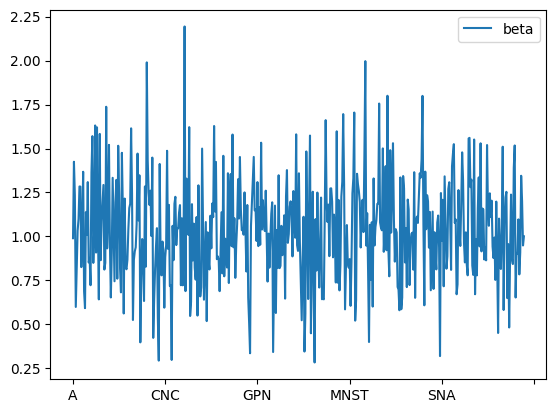

In [38]:
beta_df = pd.DataFrame.from_dict(betas, orient='index', columns=['beta'])
beta_df.plot()

---

In [2]:
precios =  pd.read_csv("../data/sp500_precios.csv", index_col=0, parse_dates=True)
precios.head(5)

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,63.381710,31.963160,37.893341,70.646538,63.908173,26.190001,131.077469,224.570007,78.138260,35.836353,...,41.850040,53.962513,35.926987,62.568439,83.576164,95.619514,156.240005,35.226196,81.659958,230.557449
2019-01-03,61.046745,29.581663,34.118874,68.318840,60.892082,25.780001,126.602242,215.699997,73.418312,35.678822,...,41.685143,53.133984,35.945953,60.423553,81.473938,93.889969,146.880005,35.031338,78.837448,225.055740
2019-01-04,63.159786,31.530161,35.575378,70.519852,62.630009,26.389999,131.524994,226.190002,75.200783,36.501442,...,42.093063,55.093021,36.988953,62.972939,83.594421,97.096619,152.970001,36.107277,81.930641,232.594147
2019-01-07,64.500923,32.425674,35.496204,71.549126,63.567928,26.330000,131.981812,229.259995,75.673691,36.685211,...,41.910801,55.379513,37.652691,62.041607,83.503029,97.134010,155.289993,36.251289,82.423607,234.428024
2019-01-08,65.446503,31.904114,36.172874,71.881653,62.804718,26.430000,135.319580,232.679993,77.519836,37.367813,...,42.396820,55.782177,37.396687,62.624863,83.338516,94.955734,156.330002,36.581703,83.651207,236.630554


In [3]:
precios = precios.iloc[:,:-1]

In [4]:
retornos = np.log(precios).diff().dropna()
matriz_cov = retornos.cov().to_numpy()
retornos_esperados = retornos.mean().to_numpy() 
num_act = len(retornos.columns)

In [5]:
#Variables de decisión
pesos = cp.Variable(num_act)

#Restricciones
constraints = [pesos >= 0,  # No shorting
               cp.sum(pesos) == 1, # Fully invested
               ]

#Función Objetivo
riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
objective = cp.Minimize(riesgo) # Minimizar la varianza

ret = retornos_esperados.T @ pesos # Retorno esperado de la cartera

#Problema y resuelvo
prob = cp.Problem(objective, constraints)
resultado = prob.solve()

#Guardamos los valores de la rentabilidad y riesgo de la cartera de mínimo riesgo
min_riesgo = np.array([riesgo.value, ret.value])


In [6]:
riesgos_lst = np.linspace(min_riesgo[0], np.diag(matriz_cov).max(), num=500)

In [7]:
retornos_lst = []
pesos_lst = []

for risk in tqdm(riesgos_lst):
 #Variables de decisión
    pesos = cp.Variable(num_act)

    # Función objetivo
    rentabilidad = cp.Maximize(retornos_esperados.T @ pesos)

    #Restricciones
    riesgo = cp.quad_form(pesos, matriz_cov)

    constraints = [pesos >= 0,
                    cp.sum(pesos) == 1,
                    riesgo <= risk
                    ]

    prob = cp.Problem(rentabilidad, constraints)
    resultado = prob.solve(solver=cp.GUROBI)
    retornos_lst.append(rentabilidad.value)
    pesos_lst.append(pesos.value)

  0%|          | 0/500 [00:00<?, ?it/s]

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Academic license 2457827 - for non-commercial use only - registered to al___@uam.es


In [9]:
from joblib import Parallel, delayed

In [10]:
def optimizar_cartera(risk, num_act, retornos_esperados, matriz_cov):
    # Variables de decisión
    pesos = cp.Variable(num_act)

    # Función objetivo
    rentabilidad = cp.Maximize(retornos_esperados.T @ pesos)

    # Restricciones
    riesgo = cp.quad_form(pesos, matriz_cov)
    constraints = [pesos >= 0, cp.sum(pesos) == 1, riesgo <= risk]

    # Resolver problema
    prob = cp.Problem(rentabilidad, constraints)
    resultado = prob.solve(solver=cp.GUROBI)

    return rentabilidad.value, pesos.value



# Paralelización con joblib
resultados = Parallel(n_jobs=-1)(delayed(optimizar_cartera)(risk, num_act, retornos_esperados, matriz_cov) for risk in tqdm(riesgos_lst, desc="Optimizando Carteras"))

# Separar los resultados en listas de retornos y pesos
retornos_lst, pesos_lst = zip(*resultados)

Optimizando Carteras:   0%|          | 0/500 [00:00<?, ?it/s]

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Academic license 2457827 - for non-commercial use only - registered to al___@uam.es
Academic license 2457827 - for non-commercial use only - registered to al___@uam.es
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Academic license 2457827 - for non-commercial use only - registered to al___@uam.es
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Academic license 2457827 - for non-commercial use only - registered to al___@uam.es
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Academic license 2457827 - for non-commercial use only - registered to al___@uam.es
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2457827
Set parameter WLSAccessID
Set para

In [11]:
num_carteras = 100000

#genero pesos aleatorios
rng= np.random.default_rng(seed=4)
pesos = rng.random((num_carteras, num_act))
pesos /= np.sum(pesos, axis=1)[:, None] #normalizo

In [12]:
#calculo retornos y volatilidades
ret_carteras = retornos @ pesos.T

volatilidades = np.sqrt(np.var(ret_carteras)*252)
rentabilidades = 252*np.mean(ret_carteras, axis=0)

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


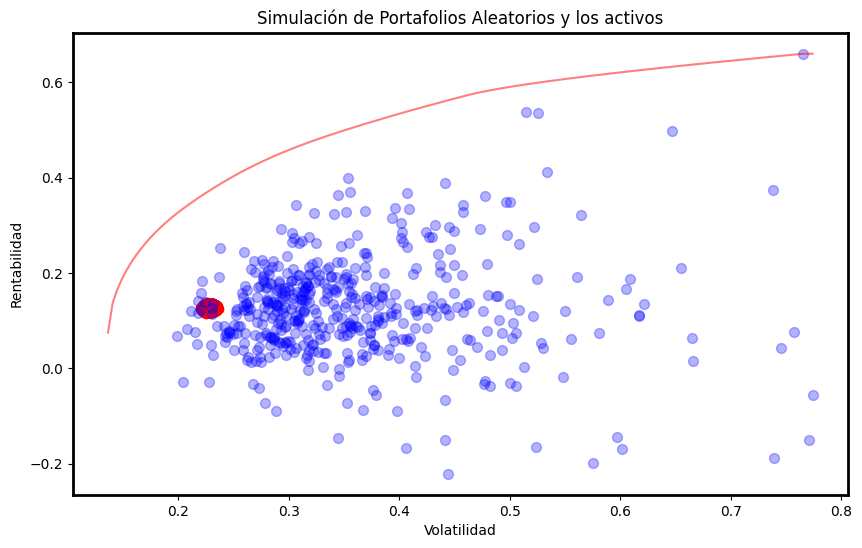

In [13]:
#grafico

plt.figure(figsize=(10, 6))
#plt.scatter(volatilidades, rentabilidades, c=rentabilidades / volatilidades, marker='o', cmap='coolwarm')
plt.scatter(volatilidades, rentabilidades, c='red', marker='o')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.3)

plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='red', label='Frontera Eficiente', alpha=0.5)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario


plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Simulación de Portafolios Aleatorios y los activos')
#plt.colorbar(label='Sharpe ratio')



# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)


plt.show()

In [14]:
def softmax_con_temperatura_matriz(pesos, temperatura):
    """
    Aplica la función softmax a cada fila de una matriz de pesos con un factor de temperatura.

    Args:
    pesos (array): Matriz de pesos, donde cada fila representa un conjunto de pesos.
    temperatura (float): Factor de temperatura para ajustar la distribución softmax.

    Returns:
    array: Matriz de pesos normalizados mediante softmax con temperatura aplicada por fila.
    """
    # Ajustar los pesos de cada fila según la temperatura
    pesos_ajustados = np.exp(pesos / temperatura)
    
    # Calcular softmax por fila
    suma_filas = np.sum(pesos_ajustados, axis=1)[:, np.newaxis]  # Sumar por filas y mantener las dimensiones
    pesos_softmax = pesos_ajustados / suma_filas
    
    return pesos_softmax

In [53]:
num_carteras = 400000

pesos = rng.random((num_carteras, num_act))

pesos = softmax_con_temperatura_matriz(pesos, 0.0015)

In [54]:
#calculo retornos y volatilidades
ret_carteras = retornos @ pesos.T

volatilidades = np.sqrt(np.var(ret_carteras)*252)
rentabilidades = 252*np.mean(ret_carteras, axis=0)

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


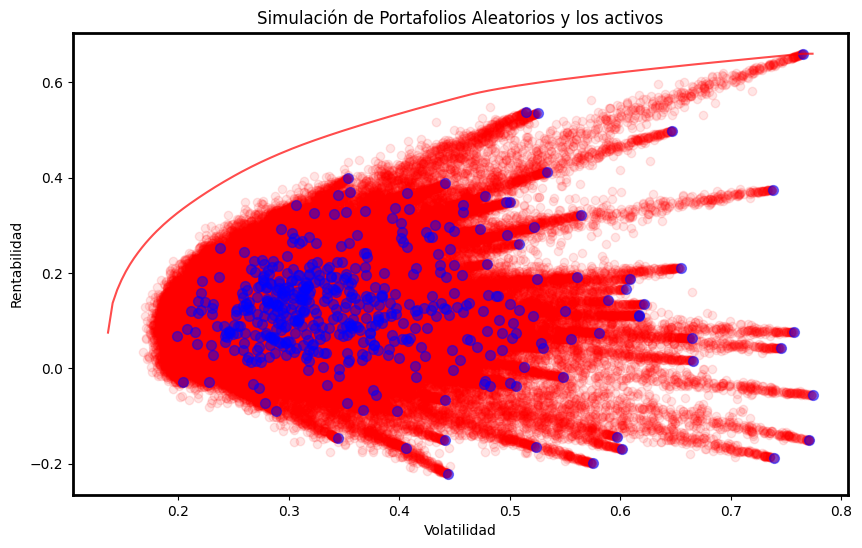

In [55]:
#grafico

plt.figure(figsize=(10, 6))
#plt.scatter(volatilidades, rentabilidades, c=rentabilidades / volatilidades, marker='o', cmap='coolwarm')
plt.scatter(volatilidades, rentabilidades, c='red', marker='o', alpha=0.1)

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.5)

plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='red', label='Frontera Eficiente', alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario


plt.xlabel('Volatilidad')
plt.ylabel('Rentabilidad')
plt.title('Simulación de Portafolios Aleatorios y los activos')
#plt.colorbar(label='Sharpe ratio')



# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)


plt.show()

In [56]:
resultados_df = pd.DataFrame({'riesgo': riesgos_lst, 'retornos': retornos_lst, 'pesos': pesos_lst})

In [58]:
resultados_df['num_activos'] = resultados_df['pesos'].apply(lambda x: sum(i > 10**-4 for i in x))

Text(0.5, 1.0, 'Número de activos en la frontera eficiente')

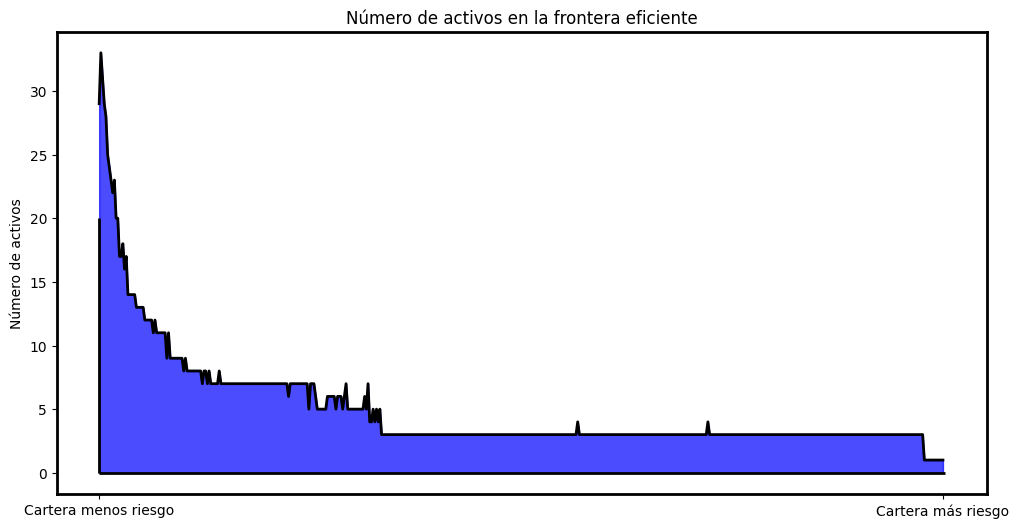

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.fill_between(resultados_df.index, resultados_df['num_activos'], color='blue', alpha=0.7)

plt.plot(resultados_df['num_activos'], color='black', lw=2)


# Personalizando los ticks del eje X
plt.xticks([0, len(resultados_df.index)-1], ['Cartera menos riesgo', 'Cartera más riesgo'], )


# Configurar el borde de la figura
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.hlines(y=0, xmin=0, xmax=500, color='black', lw=2)
plt.vlines(x=0, ymin=0, ymax=20, color='black', lw=2)

plt.ylabel('Número de activos')
plt.title('Número de activos en la frontera eficiente')

---

In [2]:
import investpy

# Define los parámetros para la descarga de los datos
accion = "AAPL"  # Ejemplo: Apple Inc
pais = "United States"  # Ejemplo: Estados Unidos
desde = "01/01/2020"  # Formato DD/MM/AAAA
hasta = "01/01/2023"  # Formato DD/MM/AAAA

# Descargar datos históricos de precios
datos_historicos = investpy.get_stock_historical_data(stock=accion,
                                                      country=pais,
                                                      from_date=desde,
                                                      to_date=hasta)

print(datos_historicos)


ConnectionError: ERR#0015: error 403, try again later.

In [4]:
investpy.get_stocks_list(country='SPAIN')

['ACS',
 'ABG',
 'A3M',
 'ACX',
 'BBVA',
 'BKT',
 'BME',
 'ANA',
 'CABK',
 'ENAG',
 'FCC',
 'NTGY',
 'SGREN',
 'GRLS',
 'FER',
 'REE',
 'ITX',
 'REP',
 'IBE',
 'IDR',
 'MAP',
 'TEF',
 'TL5',
 'SCYR',
 'SABE',
 'SAN',
 'COL',
 'TRE',
 'OHL',
 'ICAG',
 'EBRO',
 'ELE',
 'AMA',
 'BKIA',
 'DIDA',
 'VTSG',
 'ROVI',
 'GALQ',
 'SLRS',
 'AI',
 'ALNTA',
 'ALB',
 'PRS',
 'MEL',
 'GSJ',
 'NXTE',
 'ADXR',
 'MCM',
 'GCO',
 'SPSL',
 'ENC',
 'CAF',
 'UBS',
 'ISUR',
 'QBT',
 'LGT',
 'IBG',
 'BRIO',
 'ADZ',
 'RLIA',
 'IBES',
 'CBAV',
 'RDM',
 'NEA',
 'CIEA',
 'RTA4',
 'RJFE',
 'EZEN',
 'MDF',
 'ZOT',
 'BDL',
 'MTBA',
 'MVC',
 'NHH',
 'FAE',
 'TUR',
 'PVA',
 'GRLSbn',
 'BIOS',
 'VIS',
 'PSG',
 'ALM',
 'VOC',
 'VID',
 'CCMC',
 'TUBA',
 'REN',
 'FLUI',
 'ENOR',
 'AZK',
 'APAM',
 'SNCE',
 'ECR',
 'CDRE',
 'NATR',
 'APE',
 'AIR',
 'PRIM',
 'OLEO',
 'MTS',
 'ABGek',
 'LBK',
 'EBI',
 'YENT',
 'PETR4',
 'AMXL',
 'BRPO',
 'BRPP',
 'BRKM3',
 'CPLE6',
 'ELTO',
 'ELTB',
 'PETR3',
 'USIO',
 'USIM5',
 'VALO',
 'ALFAA

In [6]:
len(investpy.get_funds_list(country='SPAIN'))

4107

In [7]:
investpy.get_stock_historical_data('ALVG', country='germany', from_date='01/01/2020', to_date='01/01/2021')

ConnectionError: ERR#0015: error 403, try again later.

In [8]:
url = "https://www.investing.com/instruments/HistoricalDataAjax"

In [ ]:
       params = {
            "curr_id": id_,
            "smlID": str(randint(1000000, 99999999)),
            "header": header,
            "st_date": '01/01/2020',
            "end_date": '01/01/2021',
            "interval_sec": interval.capitalize(),
            "sort_col": "date",
            "sort_ord": "DESC",
            "action": "historical_data",
        }

In [ ]:
import requests

req = requests.post(url, headers=head, data=params)